<div style="line-height:0.5">
<h1 style="color:#BF66F2 "> Restricted Boltzmann Machines in PyTorch </h1>
<h4>  </h4>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    networkx Graph() + networkx get_node_attributes() + Gibbs sampling
</span>
</div>

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

<h3 style="color:#BF66F2 "> Recap: Energy function </h3>
<div style="margin-top: -20px;">


$ E(v,h) = - \sum_{i=1}^{n_v}{a_iv_i} - \sum_{j=1}^{n_h}{b_jh_j} - \sum_{i=1}^{n_v}\sum_{j=1}^{n_h}{v_iw_{ij}h_j}$

Free Energy is used to measure the likelihood of a given state of the system.    
The name "free energy" was adopted from thermodynamics because the concept relates to the amount of energy that is "free" <br> to be used for doing work or
being exchanged,
to describe the balance between different types of energy and the system's ability to change and evolve.

In the context of statistical models, it's about capturing the energy that is available to be "freely" transformed between different configurations of the system.<br>
The energy is equivalent to the deviation from the actual answer. The higher the energy, the more the deviation.

In [2]:
class RBM(torch.nn.Module):
    """ Restricted Boltzmann Machine (RBM) Network.

    Parameters:
        - Number of visible units [int]
        - Number of hidden units [int]

    Attributes:
        - w: Weight matrix between visible and hidden units
        - a: Bias for visible units
        - b: Bias for hidden units

    Methods:
        - sample_h(self, v): Perform sampling of hidden units given visible units.
        - sample_v(self, h): Perform sampling of visible units given hidden units.
        - forward(self, v, k=1): Forward pass through the RBM, including Gibbs sampling steps.
        - free_energy(self, v): Compute the free energy of the given visible units.
    """


    def __init__(self, num_visible, num_hidden):
        """ Initialize an RBM instance. """
        super(RBM, self).__init__()

        # Weight matrix
        self.w = torch.nn.Parameter(torch.randn(num_visible, num_hidden) * 0.01)
        # Visible bias
        self.a = torch.nn.Parameter(torch.zeros(num_visible))
        # Hidden bias
        self.b = torch.nn.Parameter(torch.zeros(num_hidden))

    def sample_h(self, v):
        """ Sample hidden units given visible units.

        Parameters:
            Visible units [nn.Tensor]

        Details:
            - Compute the Energy phv
                - Calculate dot product between the visible units and the weight matrix
                - Add the bias (self.b)
                - Map with sigmoid function to range outputs between 0 and 1 to obtain probabilities.\\
                (the likelihood of each hidden unit being activated)

            - Randomly decide whether the hidden unit should be active (1) or not active (0) based on its probability.
                - Generate a tensor of the same shape as phv, where each element is sampled from a Bernoulli distribution\\
                with probabilities defined by the tensor phv.

        Returns:
            - Sampled hidden units [nn.Tensor]
            - Probabilities of hidden units being active given visible units [nn.Tensor]
        """
        phv = torch.sigmoid(torch.matmul(v, self.w) + self.b)
        h = torch.bernoulli(phv)

        return h, phv

    def sample_v(self, h):
        """ Sample of visible units given hidden units.

        Parameters:
            h: Hidden units [nn.Tensor]

        Details:
            - Compute the Energy phv
                - Calculate dot product between the hidden units and the weight matrix
                - Add the bias (self.a)
                - Map with sigmoid function to range outputs between 0 and 1 to obtain probabilities.\\
                (the likelihood of each hidden unit being activated)

            - Randomly decide whether the visible unit should be active (1) or not active (0) based on its probability.
                - Generate a tensor of the same shape as phv, where each element is sampled from a Bernoulli distribution\\
                with probabilities defined by the tensor phv.
        Returns:
            - Sampled visible units [nn.Tensor]
            - Probabilities of hidden units being active given visible units [nn.Tensor]
        """
        pvh = torch.sigmoid(torch.matmul(h, self.w.t()) + self.a)
        v = torch.bernoulli(pvh)

        return v, pvh

    def forward(self, v, k=1):
        """ Forward pass through the RBM, to perform the "reconstruction" process of visible units after a number of\\
        Gibbs sampling steps (Contrastive Divergence)

        Parameters:
            - Visible units [nn.Tensor]
            - Number of Gibbs sampling steps [int, default=1]

        Details:
            - For k iterations:
                - Perform a single Gibbs sampling iteration
                    - Sample new states for the visible nodes (v), looking at the influence of the hidden units
                    - Sample new states for the hidden nodes (v), looking at the influence of the visible units

            - Update to the visible units based on the last states of the hidden units, to get the final approximation\\
            of the visible units.

        Returns:
            Sampled visible units [nn.Tensor]
        """
        h, phv = self.sample_h(v)

        # Gibbs sampling
        for i in range(k):
            v, pvh = self.sample_v(phv)
            h, phv = self.sample_h(v)
        v, pvh = self.sample_v(phv)

        return v

    def free_energy(self, v):
        """ Compute the Energy function of the given visible units.

        Parameters:
            v: Visible units [nn.Tensor]

        Details:
            - Compute the contribution of the visible bias term (self.a) to the energy,\\
            as the dot product of the visible unit values (v) and the visible bias.
            - Compute the logarithm and sum over the hidden units (axis 1) of:
                - 1 +  the exponentional function of:
                    - The contribution of the hidden bias term (self.b) and the interactions\\
                    between visible and hidden units to the energy,\\
                    as a dot product of the visible units (v) with the weight matrix (self.w).
                    - with the hidden bias (self.b) added
            - Combine the contributions from the visible bias and the interactions between units to compute the overall\\
            Free Energy of the given visible unit configuration\\
            Free Energy is the negative logarithm of the probability of a configuration!

        Returns:
            Free energy of the visible units [nn.Tensor]
        """
        vt = torch.matmul(v, self.a)
        ht = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.w) + self.b)), dim=1)

        energy = -(vt + ht)
        return energy


In [3]:
def train(rbm, train_loader, learning_rate, k, training_epochs, device, num_visible):
    """ Train the Restricted Boltzmann Machine (RBM) using Contrastive Divergence.

    Parameters:
        - The RBM model to train [RMB object]
        - DataLoader for training data [DataLoader]
        - Learning rate for optimization [float]
        - Number k of Gibbs sampling steps for Contrastive Divergence [k]
        - Number of training epochs [int]
    """
    optimizer = torch.optim.Adam(rbm.parameters(), lr=learning_rate)
    print("Training in starting...")
    for epoch in range(training_epochs):
        epoch_cost = 0.

        # Iterate through batches in the training data
        for batch in train_loader:
            # Reshape the batch to match the visible unit size
            batch = batch.view(-1, num_visible).to(device)
            # Perform Gibbs sampling for reconstruction
            v = rbm.forward(batch).to(device)

            ## Contrastive Divergence: Calculate cost and gradients
            cost = torch.mean(rbm.free_energy(batch)) - torch.mean(rbm.free_energy(v))
            cost = cost.to(device)

            # Update epoch cost
            epoch_cost += cost.item()

            ### Backpropagation and optimization
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        print('Epoch [{}/{}], cost: {:.4f}'.format(epoch+1, training_epochs, epoch_cost))

    print("Ok. Training done.")


In [4]:
num_visible = 3
num_hidden = 3
n_nodes = num_visible + num_hidden

In [5]:
""" Hyperparameters """
learning_rate = 0.01
epochs = 10
batch_size = 100
k = 3

In [6]:
""" Training data generation """
N = 10000
states = np.array([[1,0,0],[1,1,0],[1,0,1],[1,1,1]])
idx = np.random.choice(np.arange(len(states)), N)
data = states[idx]
data = torch.from_numpy(data)
train_loader = torch.utils.data.DataLoader(dataset = data.to(torch.float), batch_size = batch_size, shuffle = True)

In [7]:
train_loader.dataset

tensor([[1., 1., 0.],
        [1., 0., 0.],
        [1., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.]])

In [8]:
train_loader.batch_size

100

In [9]:
num_batches = len(train_loader)
num_batches

100

In [10]:
total_samples = len(train_loader) * train_loader.batch_size
total_samples

10000

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
model = RBM(num_visible, num_hidden).to(device)
train(model, train_loader, learning_rate, k, epochs, device, num_visible)

Epoch [1/10], cost: -19.8978
Epoch [2/10], cost: -10.9672
Epoch [3/10], cost: -6.2768
Epoch [4/10], cost: -4.1923
Epoch [5/10], cost: -3.1528
Epoch [6/10], cost: -2.2128
Epoch [7/10], cost: -0.8888
Epoch [8/10], cost: -1.7578
Epoch [9/10], cost: -1.6049
Epoch [10/10], cost: -0.7748


<h3 style="color:#BF66F2 "> => Predictions </h3>

In [15]:
# Set the number of samples you want to generate
num_samples = 10

# Initialize the visible units randomly (or with specific data)
initial_v = torch.bernoulli(torch.rand(num_samples, num_visible)).to(device)
initial_v

tensor([[1., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 1.],
        [1., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

In [16]:
# Generate predictions using Gibbs sampling
with torch.no_grad():
    generated_samples = model.forward(initial_v, k=k)

print("Generated Samples:")
print(generated_samples)

Generated Samples:
tensor([[1., 0., 1.],
        [1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 0., 1.]], device='cuda:0')


<h3 style="color:#BF66F2 "> => Plots </h3>

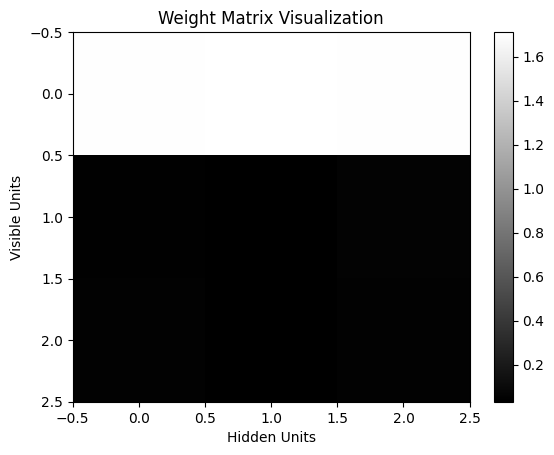

In [17]:
# Get the weight matrix
weights = model.w.detach().cpu().numpy()
# Visualize weights
plt.imshow(weights, cmap='gray', aspect='auto')
plt.xlabel("Hidden Units")
plt.ylabel("Visible Units")
plt.title("Weight Matrix Visualization")
plt.colorbar()
plt.show()


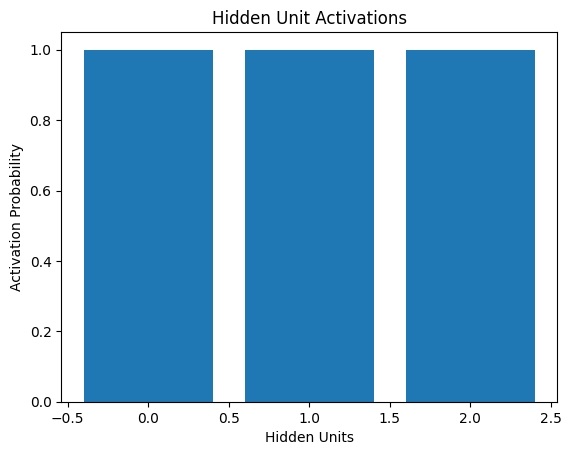

In [21]:
# Assuming you have the trained RBM model named 'model'
visible_units = torch.tensor([[1.0, 0.0, 1.0]]).to(device)  # Example visible pattern with floating-point values
with torch.no_grad():
    hidden_activations, _ = model.sample_h(visible_units)

plt.bar(range(num_hidden), hidden_activations[0].cpu().numpy())
plt.xlabel("Hidden Units")
plt.ylabel("Activation Probability")
plt.title("Hidden Unit Activations")
plt.show()


<h3 style="color:#BF66F2 "> => Visualize the RBM network </h3>

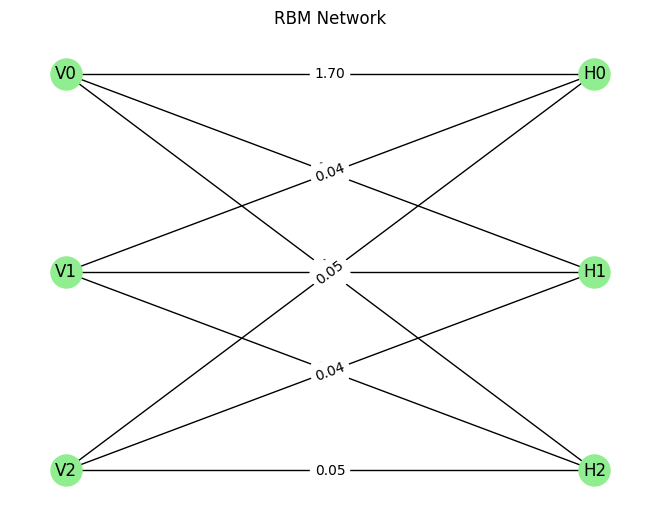

In [31]:
# Create a new networkx graph
G = nx.Graph()

# Number of visible units
nv = model.a.size(0)
# Number of hidden units
nh = model.b.size(0)

#### Add visible and hidden units as nodes
for i in range(nv):
    G.add_node(f"V{i}", pos=(0, nv - i))
for i in range(nh):
    G.add_node(f"H{i}", pos=(1, nh - i))

#### Add edges to represent connections between visible and hidden units
for i in range(nv):
    for j in range(nh):
        # Weight between V_i and H_j
        weight = model.w[i, j].item()
        G.add_edge(f"V{i}", f"H{j}", weight=weight)

# Get positions for nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightgreen')
edge_labels = {(f"V{i}", f"H{j}"): f"{G.edges[(f'V{i}', f'H{j}')]['weight']:.2f}" for i in range(nv) for j in range(nh)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("RBM Network")
plt.show()


<h2 style="color:#BF66F2 "> Metrics: </h2>

<div style="line-height:0.1">
<h3 style="color:#BF66F2 "> Reconstruction Error </h3>
<div style="line-height:1.2">
Evaluate how well the RBM can reconstruct the input data, wiht an average squared difference between the original input data <br> and the reconstructed data. Lower reconstruction error indicates better performance.
</div>
</div>

In [22]:
reconstruction_errors = []
for batch in train_loader:
    batch = batch.view(-1, num_visible).to(device)
    v_reconstructed = model.forward(batch).detach().cpu().numpy()
    reconstruction_errors.append(np.mean(np.square(batch.cpu().numpy() - v_reconstructed)))

average_reconstruction_error = np.mean(reconstruction_errors)
average_reconstruction_error

0.33396664

<h3 style="color:#BF66F2 "> Negative Log-Likelihood (NLL) </h3>
Measure the likelihood of your data given the RBM. Lower NLL values indicate better model fit to the data.

In [25]:
nll_values = []
for batch in train_loader:
    batch = batch.view(-1, num_visible).to(device)
    nll = torch.mean(model.free_energy(batch)) - torch.mean(model.free_energy(model.sample_h(batch)[0]))
    nll_values.append(nll.item())

average_nll = np.mean(nll_values)
average_nll

-0.155707426071167